# 配置环境

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print("Setup Complete")

Setup Complete


# 差分隐私处理

## Step 1 import packages

In [223]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

## Step 2 user-defined parameteres

In [224]:
# input dataset
file_name = "iris"
input_data = "./data/" + file_name + ".csv"
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f"./out/{mode}/" + file_name + "_synthetic_description.json"
synthetic_data = f"./out/{mode}/" + file_name + "_synthetic_data.csv"

input_data, description_file, synthetic_data

('./data/iris.csv',
 './out/correlated_attribute_mode/iris_synthetic_description.json',
 './out/correlated_attribute_mode/iris_synthetic_data.csv')

In [225]:
input_df = pd.read_csv(input_data)
input_df.head()

,Id,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [226]:
input_df.shape

(150, 6)

In [227]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# specify categorical attributes
# categorical_attributes = {'education': True}
categorical_attributes = {'Species': True}

# specify which attributes are candidate keys of input dataset.
# candidate_keys = {'ssn': True}
candidate_keys = {'Id': True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 500

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = input_df.shape[0] # Here input_df.shape[0] is the same as input dataset, but it can be set to another number.

## Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [228]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT Petal Width (cm)
Adding attribute Petal Length (cm)
Adding attribute Sepal Length (cm)


/home/zhoujiehui/anaconda3/lib/python3.8/site-packages/DataSynthesizer/lib/PrivBayes.py:192: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute Sepal Width (cm)
Adding attribute Species
========================== BN constructed ==========================


In [229]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    Petal Length (cm) has parents ['Petal Width (cm)'].
    Sepal Length (cm) has parents ['Petal Length (cm)', 'Petal Width (cm)'].
    Sepal Width (cm)  has parents ['Sepal Length (cm)', 'Petal Length (cm)'].
    Species           has parents ['Petal Length (cm)', 'Petal Width (cm)'].


## Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [230]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

## Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [231]:
input_df.head()

,Id,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [232]:
synthetic_df = pd.read_csv(synthetic_data)
synthetic_df.head()

,Id,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Species
0,0,4.991996,4.360717,2.443848,1.315253,Iris-virginica
1,1,6.056432,3.075986,4.811308,1.889414,Iris-virginica
2,2,6.895703,3.086966,5.019889,1.515921,Iris-versicolor
3,3,6.506605,2.921144,4.650794,1.410026,Iris-versicolor
4,4,5.112029,4.261451,2.467495,1.284704,Iris-setosa


In [233]:
synthetic_df.columns

Index(['Id', 'Sepal Length (cm)', 'Sepal Width (cm)', 'Petal Length (cm)',
       'Petal Width (cm)', 'Species'],
      dtype='object')

In [234]:
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

### 5.2 compare histograms between input and synthetic datasets.

Sepal Length (cm)
Sepal Width (cm)
Petal Length (cm)
Petal Width (cm)
Species


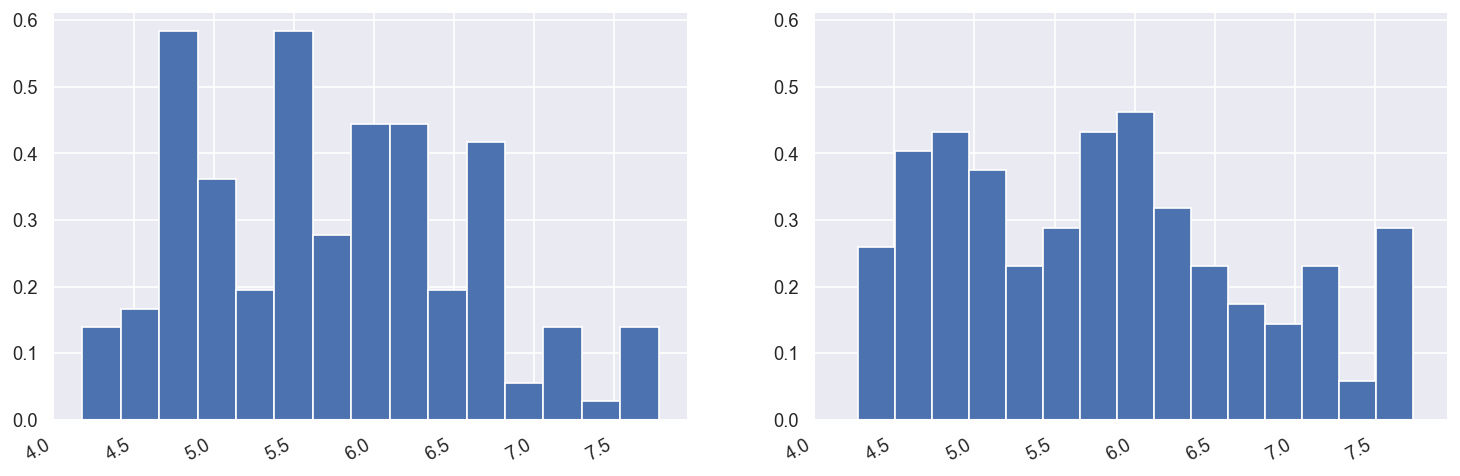

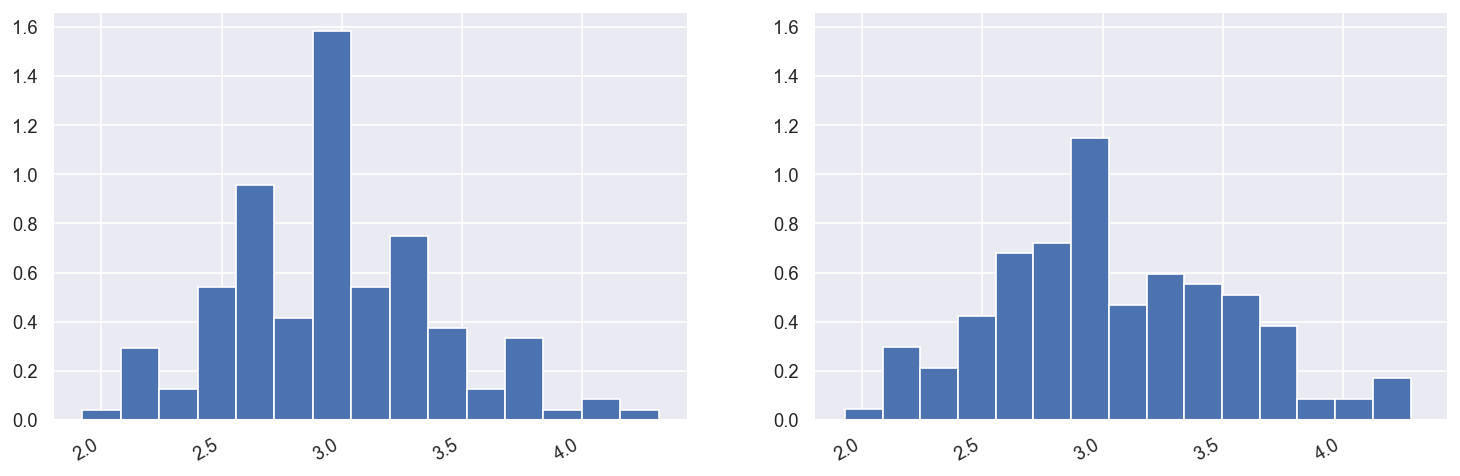

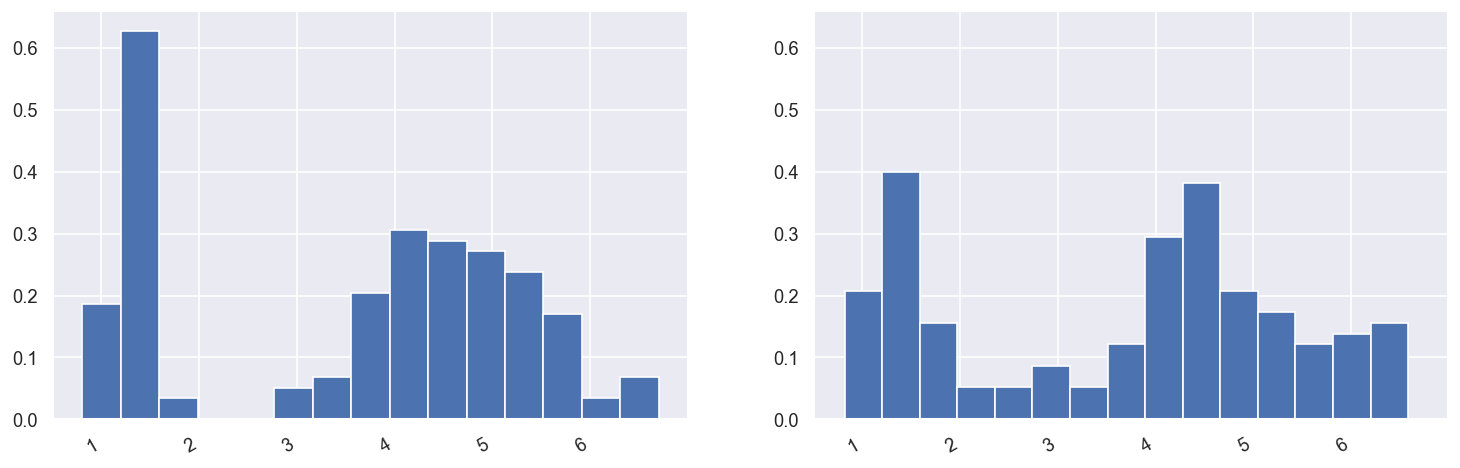

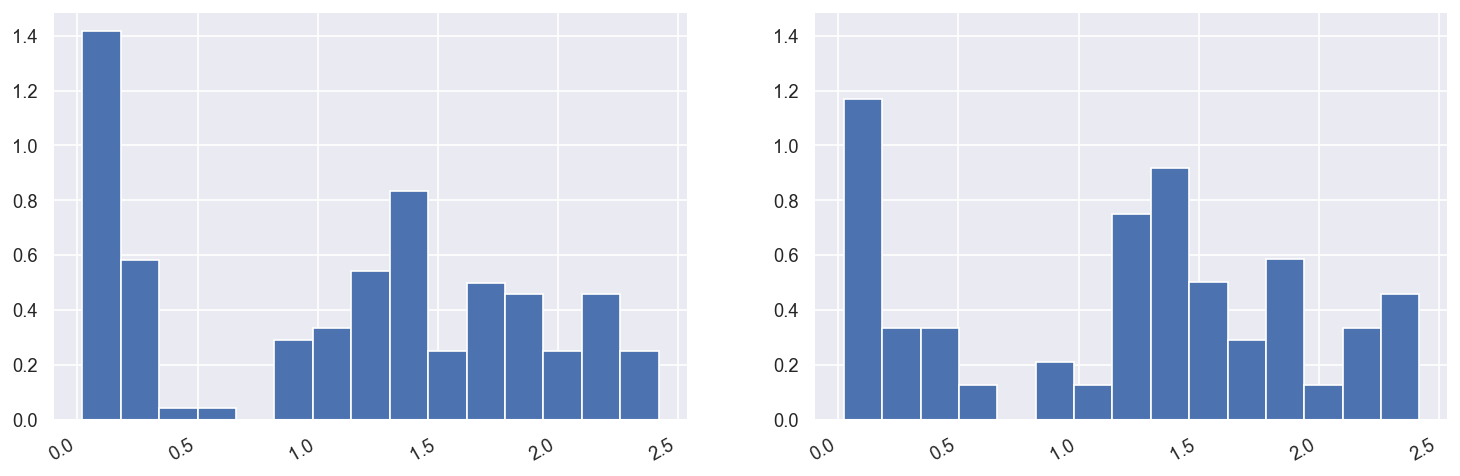

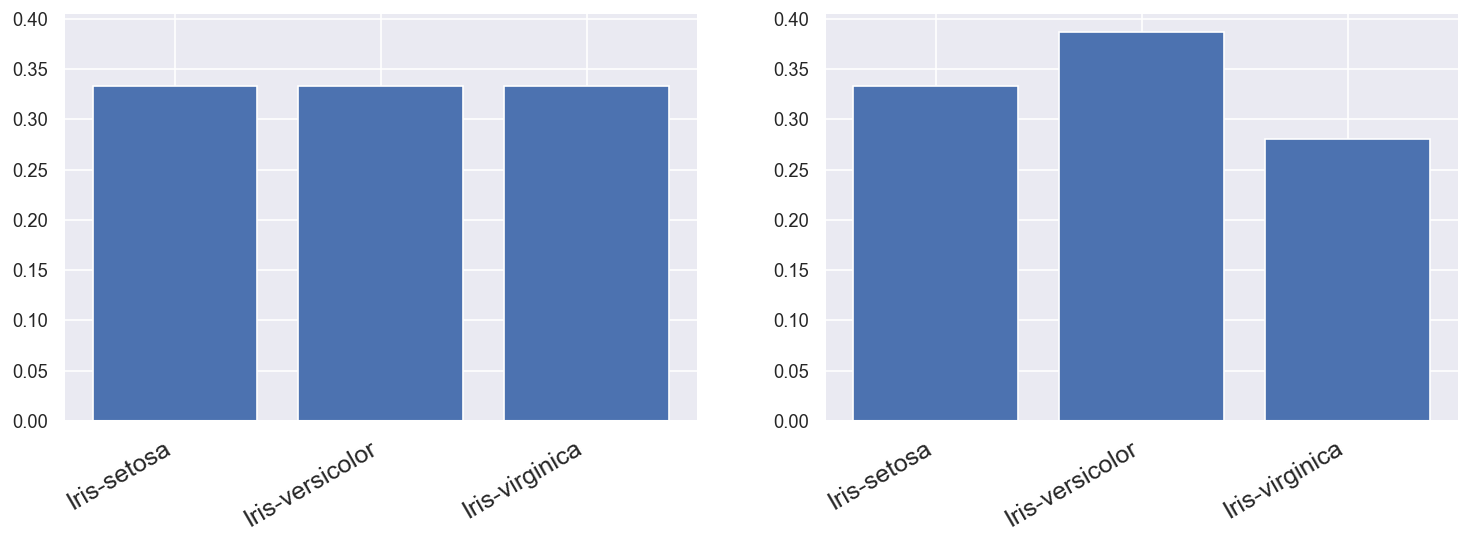

In [235]:
for attribute in synthetic_df.columns:
    print(attribute)
    inspector.compare_histograms(attribute)

### 5.3 compare pairwise mutual information

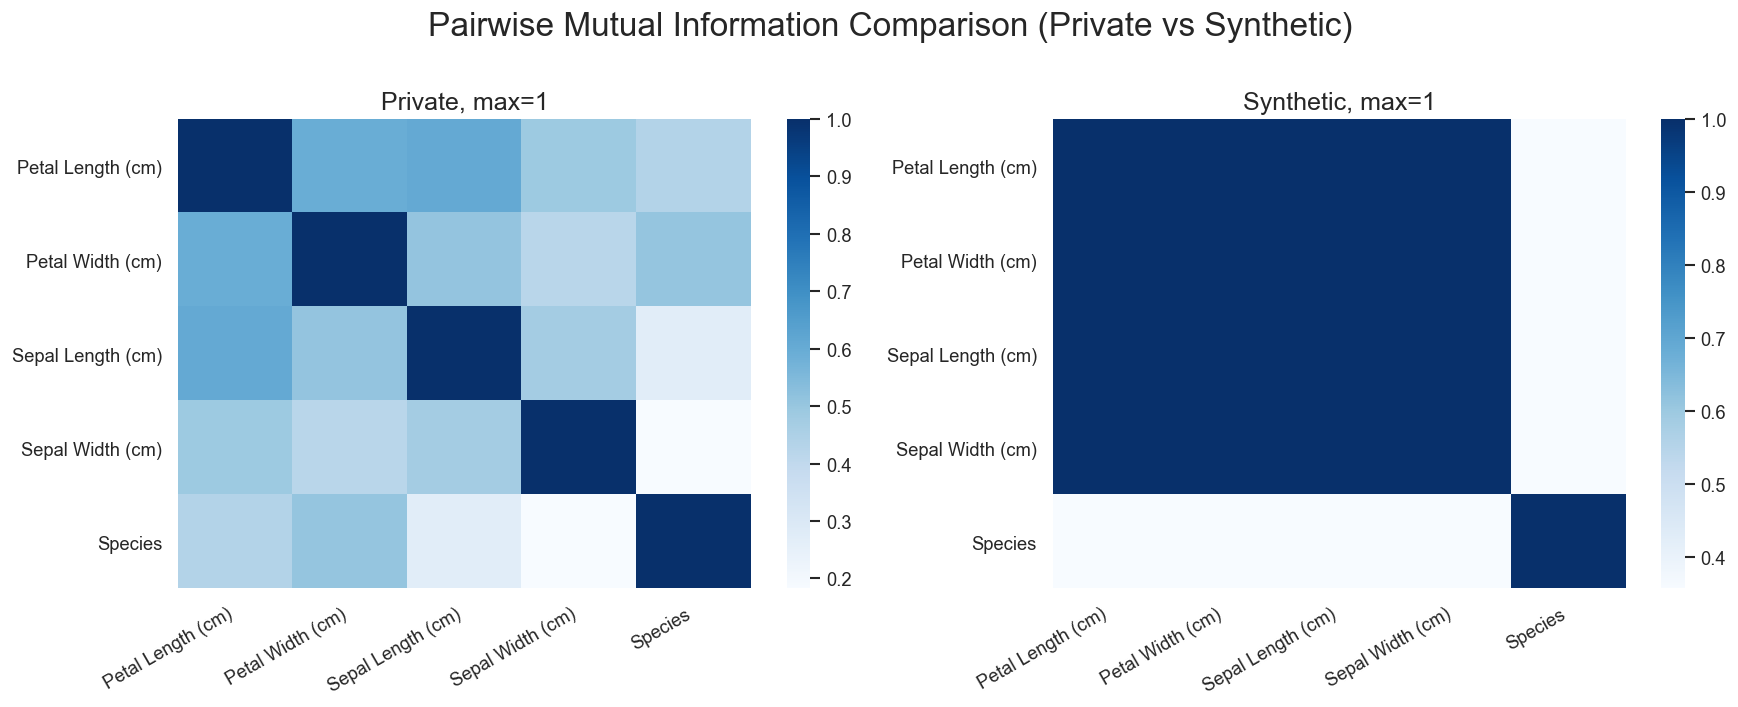

In [236]:
inspector.mutual_information_heatmap()

# 其他种类可视化的比较

In [237]:
iris_set_data = input_df.loc[input_df['Species'] == 'Iris-setosa']
iris_ver_data = input_df.loc[input_df['Species'] == 'Iris-versicolor']
iris_vir_data = input_df.loc[input_df['Species'] == 'Iris-virginica']

/home/zhoujiehui/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


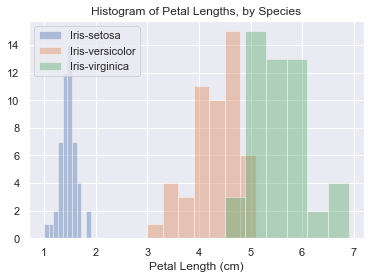

In [238]:
# Histograms for each species
sns.distplot(a=iris_set_data['Petal Length (cm)'], label="Iris-setosa", kde=False)
sns.distplot(a=iris_ver_data['Petal Length (cm)'], label="Iris-versicolor", kde=False)
sns.distplot(a=iris_vir_data['Petal Length (cm)'], label="Iris-virginica", kde=False)

# Add title
plt.title("Histogram of Petal Lengths, by Species")

# Force legend to appear
plt.legend()

In [239]:
iris_set_synthetic_data = synthetic_df.loc[synthetic_df['Species'] == 'Iris-setosa']
iris_ver_synthetic_data = synthetic_df.loc[synthetic_df['Species'] == 'Iris-versicolor']
iris_vir_synthetic_data = synthetic_df.loc[synthetic_df['Species'] == 'Iris-virginica']

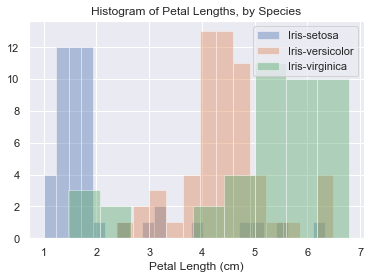

In [240]:
# Histograms for each species
sns.distplot(a=iris_set_synthetic_data['Petal Length (cm)'], label="Iris-setosa", kde=False)
sns.distplot(a=iris_ver_synthetic_data['Petal Length (cm)'], label="Iris-versicolor", kde=False)
sns.distplot(a=iris_vir_synthetic_data['Petal Length (cm)'], label="Iris-virginica", kde=False)

# Add title
plt.title("Histogram of Petal Lengths, by Species")

# Force legend to appear
plt.legend()